-------------------------------------------------------------------
# Homework set 4 - solution

 * **Author**: Balint Szoke
 * **UniID**: bs2574

> This notebook shows downward bias in the OLS estimate of the correlation 
coefficient in an AR(1) regression. In addition, it demonstrates the power of `numba` in making loops run faster

-------------------------------------------------------------------


In [31]:
%matplotlib inline
import numpy as np
import scipy as sp
import seaborn as sb
import scipy.stats as stats
import matplotlib.pyplot as plt
from numba import jit

## (1) Downward bias in the OLS estimate of the correlation coefficient in AR(1)

Consider the simple AR(1) process

$$X_{t+1} = \beta + \alpha X_{t} + \sigma W_{t+1}\hspace{1cm}W_{t+1}\sim\mathcal{N}(0,1)$$

and use OLS to estimate the parameter $\alpha$ from a given sample size $N$

In order to calculate the bias, we have to simulate a lot. Becuase this part is the slowest, it makes sense to write a separate function for this task that we can later pass on to numba. 

In [32]:
def sample_path(alpha, beta, sigma, N, x0=None):
    '''
    Simulates the sample path for X of length N+1 starting from a specified initial value OR if x0 
    is None, it initializes the path with a draw from the stationary distribution of X. 
    
    Arguments
    -----------------
        alpha (Float) : slope coefficient 
        beta (Float)  : intercept term
        sigma (Float) : standard deviation of the error
        N (Int)       : length of the sample path without x0
        x0 (Float)    : initial value of X
    
    Return:
    -----------------
        x_path (Numpy Array) : simulated path
        
    '''
    if x0 == None:
        # Draw the initial value from the stationary distribution
        mean_erg = beta / (1 - alpha)
        stdev_erg = sigma/np.sqrt(1-alpha**2) 
        x0 = np.random.normal(mean_erg, stdev_erg)
    
    # Memory:
    x_path = np.empty(N+1)
    x_path[0] = x0
    w_path = np.random.normal(0, 1, N)
    
    for t in range(N):
        x_path[t + 1] = beta + alpha*x_path[t] + sigma*w_path[t]
    
    return x_path 

As an OLS estimator I use the built-in function `linregress` (part of `scipy.stats`):

In [33]:
def ols_estimate(x_path):
    '''
    This function takes the sample path for X and calculates the OLS estimate for the correlation coefficient
    for the AR(1) model. It requires scipy.stats 
    '''
    # Define the left (y=X_{t+1})  and right hand side variables (x = X_t) 
    y, x = x_path[1:], x_path[:-1]
    
    # Fit the model 
    alpha_hat, beta_hat, R2, p, se = stats.linregress(x, y)
    
    return alpha_hat

Approximate the bias, which is defined as

$$ \mathbb{E}[\hat{\alpha}_N] - \alpha$$

where $\hat{\alpha}_N$ denotes the OLS estimate for the autoregressive coefficient for a sample size $N$. Downward bias means $ \mathbb{E}[\hat{\alpha}_N] < \alpha$, i.e. we expect this number to be negative.

In [34]:
def bias(M, alpha, beta, sigma, N):
    '''
    This function approximates the bias by drawing M simulations 
    for a given set of parameters (alpha, beta, sigma) and for a given sample size N
    It is meant to be fast (even without numba)
    '''
    
    alpha_hats = np.asarray([ ols_estimate(sample_path(alpha, beta, sigma, N)) for i in range(M) ])
    
    return alpha_hats.mean() - alpha 

Let's study how fast are these so far

In [40]:
N, M = 500, 20000                # largest sample size and a relatively large number to get good approx
xx = sample_path(.5, 1., 1., N)  # sample path to test ols_estimate 

sp_won = %timeit -o sample_path(.5, 1., 1., N)
ols_won = %timeit -o ols_estimate(xx)
bias_won = %timeit -o bias(M, .5, 1., 1., N)

The slowest run took 5.36 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 265 µs per loop
10000 loops, best of 3: 148 µs per loop
1 loop, best of 3: 9.48 s per loop


## (2) Use `numba` to make things faster

Let's make some magic with a few lines

In [41]:
sample_path_numba = jit(sample_path)
ols_estimate_numba = jit(ols_estimate)    # I would be REALLY surprised if numba could speed this up

@jit
def bias_numba(M, alpha, beta, sigma, N):
    summ = np.zeros(M)
    for i in range(M):
        summ[i] = ols_estimate_numba(sample_path_numba(alpha, beta, sigma, N))
    alpha_hats = np.asarray(summ)
    
    return alpha_hats[1:].mean() - alpha 

In [42]:
sp_wn = %timeit -o sample_path_numba(.5, 1., 1., N)
ols_wn = %timeit -o ols_estimate_numba(xx)
bias_wn = %timeit -o bias_numba(M, .5, 1., 1., N)

The slowest run took 7595.39 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 33.3 µs per loop
The slowest run took 517.20 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 152 µs per loop
1 loop, best of 3: 4.21 s per loop


In [43]:
print('{0:13s} |  {1:7s}  | {2:7s}   | {3:7s}'.format("Comparison", "No numba", " numba", "Relative"))
print('-------------------------------------------------')
print('{0:13s} |  {1:1.3f} ms  | {2:1.3f} ms  |   {3:2.1f}'.format("sample_path", 1e3*sp_won.best, 1e3*sp_wn.best,\
                                                              sp_won.best/sp_wn.best))
print('{0:13s} |  {1:1.3f} ms  | {2:1.3f} ms  |   {3:2.1f}'.format("ols_estimate", 1e3*ols_won.best, 1e3*ols_wn.best,\
                                                              ols_won.best/ols_wn.best))
print('{0:13s} |  {1:2.3f}  s  | {2:2.3f}  s  |   {3:2.1f}'.format("bias", bias_won.best, bias_wn.best,\
                                                              bias_won.best/bias_wn.best ))

Comparison    |  No numba  |  numba    | Relative
-------------------------------------------------
sample_path   |  0.265 ms  | 0.033 ms  |   8.0
ols_estimate  |  0.148 ms  | 0.152 ms  |   1.0
bias          |  9.484  s  | 4.210  s  |   2.3


## (3) Learning about the bias

Investigate the properties of the estimator by plotting the bias for different sample sizes and different (true) `alpha` values.

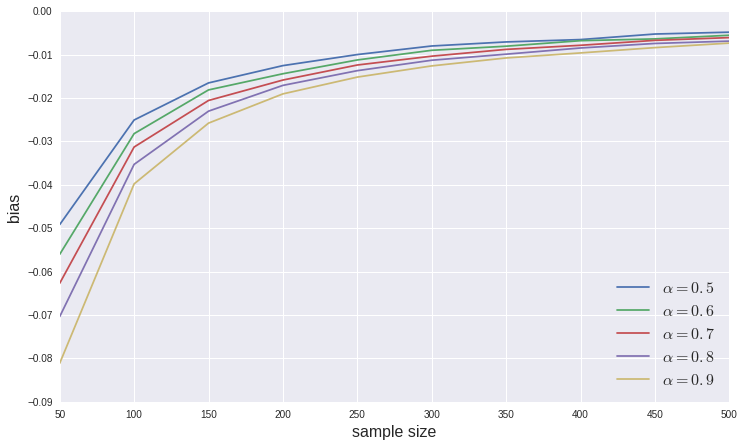

In [39]:
alphas = [.5, .6, .7, .8, .9]                 # possible alphas
sample_sizes = np.arange(50, 550, 50)     # possible sample sizes

fig, ax = plt.subplots( figsize = (12, 7))
for a in alphas:    
    ax.plot(sample_sizes, [bias_numba(M, a, 1., 1., N) for N in sample_sizes], label = r'$\alpha = {:1.1f}$'.format(a))
ax.legend(loc='best', fontsize = 16)
ax.set_ylabel('bias', fontsize = 16)
ax.set_xlabel('sample size', fontsize = 16)
plt.show()

**Main lessons:**

- Not surprisingly, the approximate bias decreases with the sample size for any given $\alpha$, because the OLS estimator is consistent, hence the LLN must kick in (sooner or later). 

- On top of this, we can see that for any given sample size $N$, the (absolute value of) approximate bias increases as the true value of $\alpha$ is getting closer to $1$. Essentially, in the formula for the OLS estimator $\alpha$ multipies the covariance between $X_t$ and $W_{t+1}$ and this covariance is non-zero in the AR(1) model (this is exactly where the bias comes from).   
